# Building/Reading a Working MNIST Classifier

## Copyright notice

Parts of this code are adapted from the [Pytorch example](https://github.com/pytorch/examples/blob/master/mnist/main.py), [BSD-3-Clause License](https://github.com/pytorch/examples/blob/master/LICENSE). This version (c) 2019 Fabian Offert, [MIT License](LICENSE).

## Learn more

- Understanding softmax and NLL: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
- Visualizing MNIST (Chris Olah): http://colah.github.io/posts/2014-10-Visualizing-MNIST/
- Pytorch: https://pytorch.org/
- Pytorch samples: https://github.com/pytorch/examples
- Convolution arithmetic: https://github.com/vdumoulin/conv_arithmetic

## Imports

In [13]:
import torch as t
import torch.nn as nn
import torch.nn.functional as f
import torchvision as tv
import matplotlib.pyplot as plt # conda install matplotlib
import numpy as np
from scipy.special import expit as sigmoid # conda install scipy

## PyTorch building blocks

### nn.Conv2d: Convolutional layer 

https://pytorch.org/docs/stable/nn.html#conv2d

Defines a number of trainable convolution kernels with fixed size and stride.

![](img/conv.gif)

Implementing convolution from scratch makes visible what it really does:

In [94]:
# We need a few helper functions to display/compare

import PIL.Image
import IPython.display
from io import BytesIO
from scipy.ndimage import convolve as scipy_convolve

def show_img_PIL(img, fmt='jpeg'):
    f = BytesIO()
    img.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

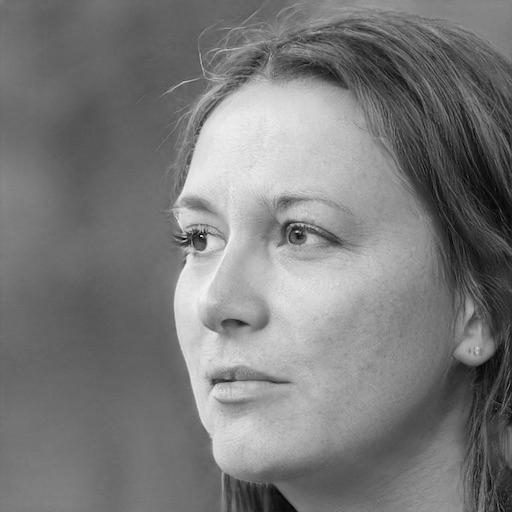

In [95]:
# Open image, convert to grayscale, and display
img_PIL = PIL.Image.open('img/person.jpg').convert('L')
show_img_PIL(img_PIL)

# Convert image to NumPy array
img = np.array(img_PIL)

# Define Gaussian blur kernel
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
kernel = 1/16 * np.array([[1,2,1],[2,4,2],[1,2,1]])

In [96]:
def custom_convolve(img, kernel):
    # Reserve new memory
    new_img = np.zeros_like(img)
    
    # Border
    img_with_border = np.zeros((img.shape[0]+2,img.shape[1]+2), dtype=img.dtype)
    img_with_border[1:-1,1:-1] = img
    
    # Transpose
    # https://en.wikipedia.org/wiki/Transpose  
    kernel = kernel.T
    
    # Iterate over image
    for x in range(1, img_with_border.shape[0]-1): # Exclude the border as focus
        for y in range(1, img_with_border.shape[1]-1): # Exclude the border as focus
            new_value = img_with_border[x-1,y-1]*kernel[0,0] + \
                        img_with_border[x,y-1]*kernel[1,0] + \
                        img_with_border[x+1,y-1]*kernel[2,0] + \
                        img_with_border[x-1,y]*kernel[0,1] + \
                        img_with_border[x,y]*kernel[1,1] + \
                        img_with_border[x+1,y]*kernel[2,1] + \
                        img_with_border[x-1,y+1]*kernel[0,2] + \
                        img_with_border[x,y+1]*kernel[1,2] + \
                        img_with_border[x+1,y+1]*kernel[2,2]
            new_img[x-1,y-1] = new_value
    return new_img

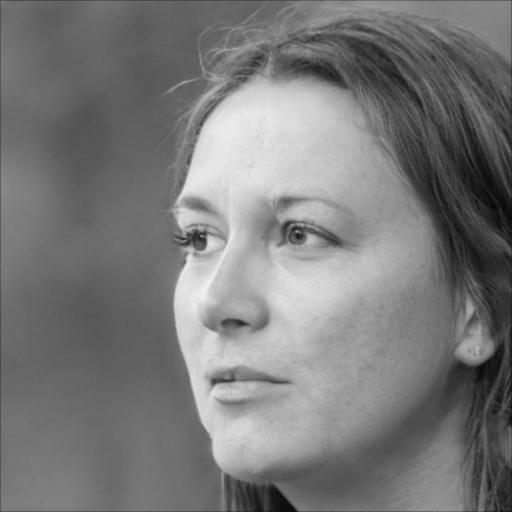

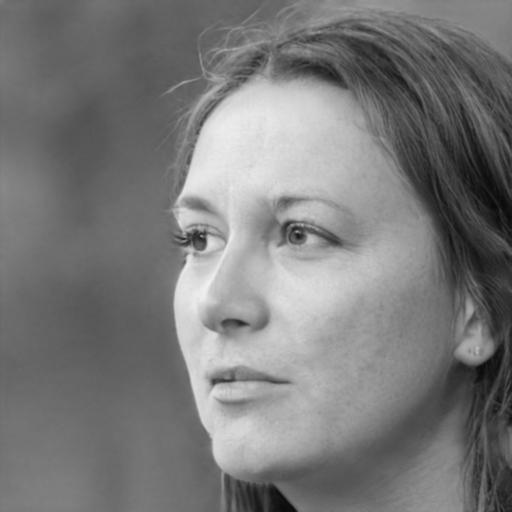

In [97]:
# Do convolution and show for both custom and SciPy versions
show_img_PIL(PIL.Image.fromarray(custom_convolve(img, kernel)))
show_img_PIL(PIL.Image.fromarray(scipy_convolve(img, kernel)))

### f.max_pool2d: Max pooling layer

https://pytorch.org/docs/stable/nn.html#maxpool2d

Only keeps the maximum value from a region of values.

### nn.Linear: Fully connected layer

https://pytorch.org/docs/stable/nn.html#linear

This is the standard, multilayer perceptron layer, where every unit of a layer is connected to every unit of the layer before and after. 

### f.relu: ReLu activation function

[Rectified linear units](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) are the most popular neural network units at the time of writing. Despite their "linear look", the [activation function](https://en.wikipedia.org/wiki/Activation_function) used: 

$$f(x)=\max(0,x)$$

is actually nonlinear ([piecewise-linear](https://en.wikipedia.org/wiki/Piecewise_linear_function), to be precise) *and* differentiable. Why nonlinear? Well, a linear function has to satisfy the condition 

$$\forall_{x,y}: f(x) + f(y) = f(x+y)$$

For ReLu, 

$$f(-1) = -1$$
$$f(1) = 1$$
$$f(0) = 0$$ 

Its derivative is then simply 

$$f'(x)={\begin{cases}0&{\text{for }}x<0\\1&{\text{for }}x\geq 0\end{cases}}$$

Interestingly, the "almost-linearity" of ReLus does not impede their universality in approximating functions (see [these examples](https://www.quora.com/Is-a-single-layered-ReLu-network-still-a-universal-approximator/answer/Conner-Davis-2)).

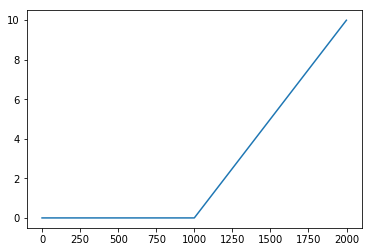

In [29]:
plt.plot([max(0, x) for x in np.arange(-10.0,10.0,0.01)])
plt.show()

### f.log_softmax + f.nll_loss: Logarithm of sigmoid loss function, or Negative Log Likelihood (NLL)

https://pytorch.org/docs/stable/nn.html#log-softmax and https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss

The [sigmoid function](https://en.wikipedia.org/wiki/Logistic_function), also called logistic function, looks roughly like the simple step function but has non-zero gradients everywhere, which makes it fully differentiable. It is defined as

$$f(x)={\frac {1}{1+e^{-x}}}$$

with the derivative

$$f'(x)=f(x)(1-f(x))$$

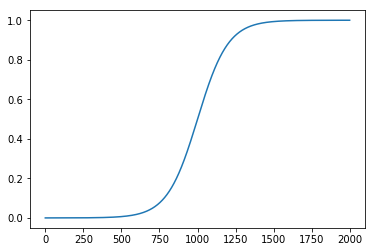

In [32]:
plt.plot([sigmoid(x) for x in np.arange(-10.0,10.0,0.01)])
plt.show()

/Users/fabian/miniconda3/envs/py37-art185ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


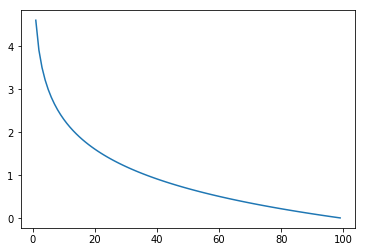

In [33]:
plt.plot([-np.log(x) for x in np.arange(0.0,1.0,0.01)])
plt.show()

### f.nll_loss.backward(): Backpropagation via stochastic gradient descent

First, a quick derivative reminder:

$$\frac{df}{dx} = \lim_{x \to +\infty} \frac{f(x+h)-f(x)}{h}$$

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is based on the observation that if the multi-variable function $f(x)$ is defined and differentiable in a neighborhood of a point $a$, then $f(x)$ decreases fastest if one goes from $a$ in the direction of the negative gradient of $f$ at $a$, $f(a) -\nabla f(a)$. The algorithm for a system with the loss function $Loss$ would then be

$$w_n \leftarrow w_n - \underbrace{\eta}_\text{step size} \nabla_{w_{n}} Loss(w_n)$$

for every training sample, where $\nabla_{w_{n}}$ ([Del](https://en.wikipedia.org/wiki/Del)) denotes the partial derivative w. r. t. the weight $w_n$, which can usually be derived by means of the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$(f\circ g)'=(f'\circ g)\cdot g'$$

[Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) adds an additional element to the process to increase throughput: batch size. Instead of supplying one training sample per iteration (where iteration defines one forward and backward pass), multiple (random) samples are concatenated and the network is trained on these concatenated "mini-batches". Essentially, we are trading dimensionality for speed which is intuitively a good choice if we use GPUs for training.

Example: $f(x)=x^4−3x^3+2$, with derivative $f'(x)=4x3−9x^2$

In [39]:
# From calculation, it is expected that the local minimum occurs at x=9/4

x = 6 # The algorithm starts at x=6
eta = 0.01 # Step size multiplier
precision = 0.00001
previous_step_size = 1/precision # Some large value

df = lambda x: 4 * x**3 - 9 * x**2

while previous_step_size > precision:
    prev_x = x
    x += -eta * df(prev_x)
    previous_step_size = abs(x - prev_x)

print("The local minimum occurs at " + str(x))

The local minimum occurs at 2.2499646074278457


## Building the model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # in, out, size, stride 
        self.conv2 = nn.Conv2d(20, 50, 5, 1) # in, out, size, stride 
        self.fc1 = nn.Linear(4*4*50, 500) # in, out
        self.fc2 = nn.Linear(500, 10) # in, out

    def forward(self, x):
        # [64, 1, 28, 28]
        x = f.relu(self.conv1(x)) # [64, 20, 24, 24]
        x = f.max_pool2d(x, 2, 2) # [64, 20, 12, 12]
        x = f.relu(self.conv2(x)) # [64, 50, 8, 8]
        x = f.max_pool2d(x, 2, 2) # [64, 50, 4, 4]
        x = x.view(-1, 4*4*50) # [64, 800]
        x = f.relu(self.fc1(x)) # [64, 500]
        x = self.fc2(x) # [64, 10]
        x = f.log_softmax(x, dim=1) # [64, 10]
        return x

## Training and testing

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = f.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # item(): https://pytorch.org/docs/stable/tensors.html#torch.Tensor.item
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with t.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += f.nll_loss(output, target, reduction='sum').item() # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # Get the index of the max log-probability
            # eq(): https://pytorch.org/docs/stable/torch.html#torch.eq
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Run everything

In [ ]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")

transform = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])

train_set = tv.datasets.MNIST('.', train=True, transform = transform)
test_set = tv.datasets.MNIST('.', train=False, transform = transform)
train_loader = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = t.utils.data.DataLoader(test_set, batch_size=1000, shuffle=True)

model = Net().to(device)
optimizer = t.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1, 10 + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)